In [23]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

# Using tf.data.AUTOTUNE directly
AUTO = tf.data.AUTOTUNE

import warnings
warnings.filterwarnings('ignore')  # Hides warnings



## Data Collection

In [4]:
images = glob('/kaggle/input/skin-cancer-malignant-vs-benign/train/*/*.jpg')
print(f"Number of images: {len(images)}")

Number of images: 2637


## Data Preprocessing

In [5]:
# Replace backslashes with forward slashes (if any)
images = [path.replace('\\', '/') for path in images]

# Create DataFrame
df = pd.DataFrame({'filepath': images})

# Check the DataFrame structure before extracting labels
# print(df.head())

# Extract the label (second-to-last part of the path)
# Adjust index to -2 if the structure is /main_folder/label/filename
df['label'] = df['filepath'].str.split('/', expand=True).iloc[:, -2]

# Print the DataFrame to verify labels
df

,filepath,label
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


In [8]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df

,filepath,label,label_bin
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
...,...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1


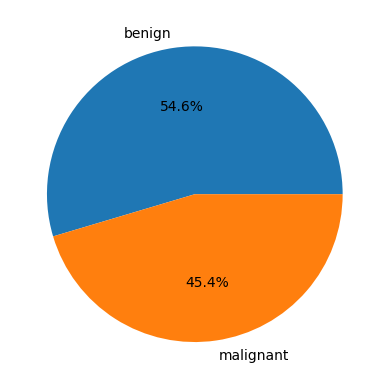

In [9]:
x = df['label'].value_counts()
plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
plt.show()


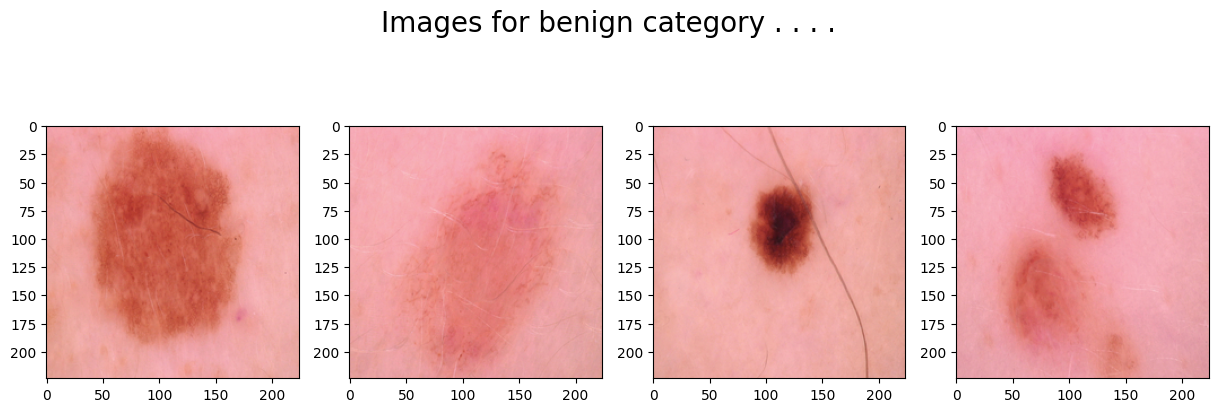

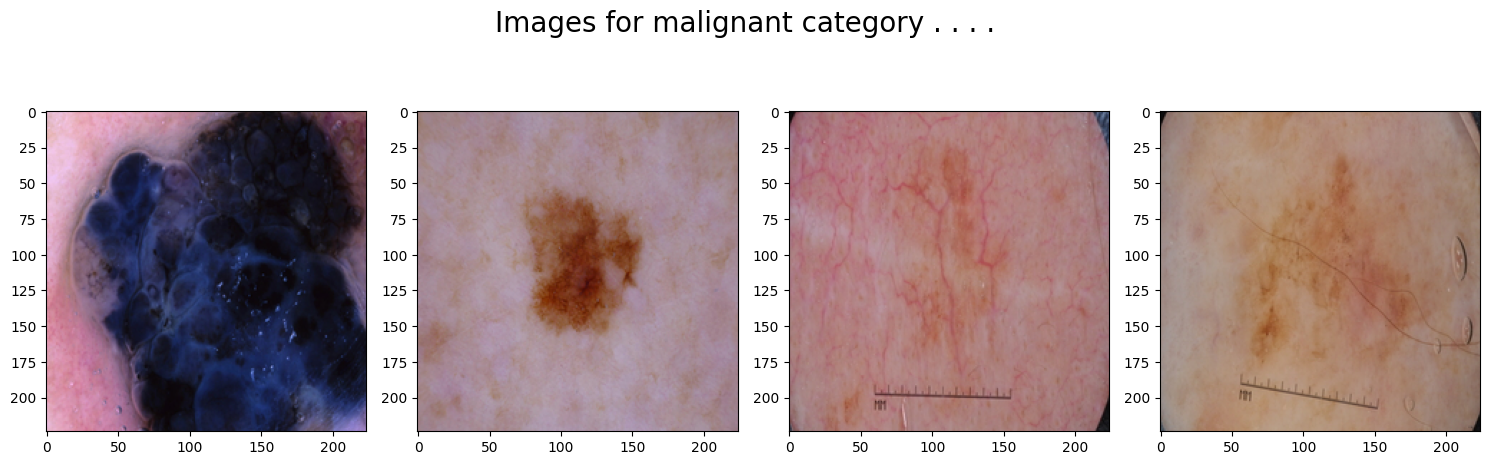

In [10]:
for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


## Image decoding function

In [13]:
def decode_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # Normalize image
    
    # Ensure label is an integer
    label = tf.cast(label, tf.int32)

    return img, label

In [14]:
# Test decoding function
test_filepath = X_train.iloc[0]
test_label = Y_train.iloc[0]

# Ensure test_label is an integer
img, label = decode_image(test_filepath, test_label)
print(f"Test image shape: {img.shape}")
print(f"Test label: {label.numpy()}")  # Convert tensor to numpy for printing


Test image shape: (224, 224, 3)
Test label: 1


In [15]:
print(f"Type of test_label: {type(test_label)}")


Type of test_label: <class 'numpy.int64'>


## Dataset creation

In [50]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)

X_train.shape, X_val.shape

((2241,), (396,))

In [51]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare the test dataset (split 80% for training and testing)
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=10)

test_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_test, Y_test))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

X_train.shape, X_test.shape

((2109,), (528,))

## Model Definition

In [52]:
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

## Train Model

In [53]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [55]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)


Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - accuracy: 0.7120 - loss: 0.5879 - val_accuracy: 0.5455 - val_loss: 3.7374
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - accuracy: 0.7818 - loss: 0.4568 - val_accuracy: 0.6995 - val_loss: 0.5580
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.8045 - loss: 0.4330 - val_accuracy: 0.7904 - val_loss: 0.4401
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step - accuracy: 0.8033 - loss: 0.4073 - val_accuracy: 0.7652 - val_loss: 0.6201
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.8323 - loss: 0.3866 - val_accuracy: 0.7929 - val_loss: 0.4551


## Test Model

In [65]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
print(f'Test accuracy: {test_accuracy:.4f}')

17/17 - 1s - 57ms/step - accuracy: 0.7936 - loss: 0.4430
Test accuracy: 0.7936


## Visualization

In [58]:
# Convert history to DataFrame
hist_df = pd.DataFrame(history.history)
hist_df

,accuracy,loss,val_accuracy,val_loss
0,0.736278,0.541744,0.545455,3.737445
1,0.768853,0.473859,0.699495,0.558020
2,0.792057,0.442062,0.790404,0.440094
3,0.794734,0.422155,0.765152,0.620085
4,0.815261,0.398629,0.792929,0.455061


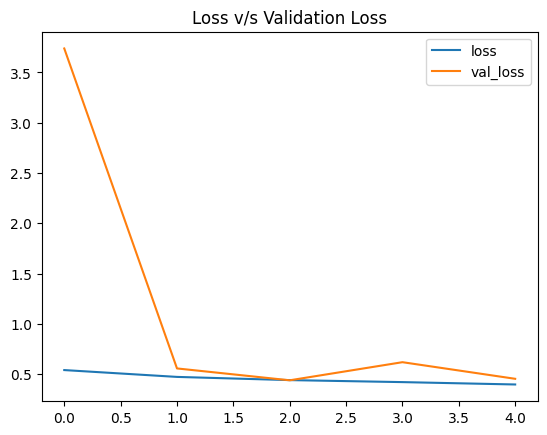

In [60]:

hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

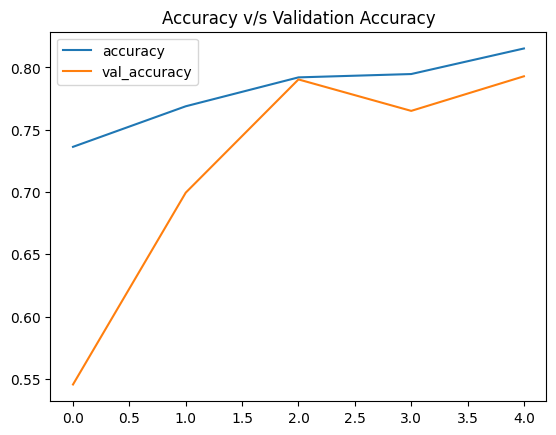

In [64]:
hist_df['accuracy'].plot()
hist_df['val_accuracy'].plot()
plt.title('Accuracy v/s Validation Accuracy')
plt.legend()
plt.show()